## Import packages and initialize directories

In [4]:
import glob
import pandas as pd
import pickle
import scipy.io as sio
from scipy.io import loadmat
import unittest
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

beh_dir = '../data/decision-making/data/data_behav'
neur_dir = '../data/decision-making/data/data_ephys'
preproc_dir = '../data/decision-making/data/data_preproc'

beh_files = [file for file in glob.glob(os.path.join(beh_dir,"gamble.data*.csv"))]
neur_files = [file for file in glob.glob(os.path.join(neur_dir,"*.mat"))]

sfreq = 1000

## Check number of electrodes per subject

In [5]:
# num_elecs=0
# for subject, file in enumerate(neur_files):
#     neur = loadmat(file)['buttonpress_events_hg']
#     print()
#     print(subject)
#     print(neur.shape)
#     num_examples += neur.shape[0]*neur.shape[2] # number of trials * number of electrodes in a subject

It really looks like there are some subejcts with 60 electrode contacts. This is great!
So actually, we have about 200 electrodes, and >36k examples to train on.

## Create df where each row corresponds to 1 subject-electrode-trial = 1 example

In [6]:
# read bad_trials, for exclusion
bad_trials = sio.loadmat(os.path.join(beh_dir, 'bad_trials_OFC.mat'))['bad_trials_OFC']

# read game_model which, we hope, is identical across subjects
game_model = pd.read_csv(os.path.join(beh_dir,'gamble_choices.csv'))

# make master df where you append each subject's df
df_master = pd.DataFrame(columns = ['subject', 
                                    'include.trial', 
                                    'round', 
                                    'newround.time', 
                                    'choice.time',
                                    'buttonpress.time', 
                                    'conf.time', 
                                    'reveal.time', 
                                    'choice.class',
                                    'choice.location', 
                                    'outcome', 
                                    'Safe.Bet.Amount', 
                                    'Risky.Bet.Amount',
                                    'Risky.bet.shown.number', 
                                    'Risky.bet.hidden.number', 
                                    'Risky.Side',
                                    'data', 
                                    'channel'])

for sub_index, files in enumerate(zip(beh_files, neur_files)):
    beh_file = files[0]
    neur_file = files[1]
    
    print(sub_index)
    print()
    
    ## Read data
    # ------------------------------------------------------------------------------------------------------.
    # behavior
    df = pd.DataFrame()
    df = pd.read_csv(os.path.join(beh_file))
    
    # neural
    neur = loadmat(neur_file)['buttonpress_events_hg']
    
    ## Number trials and number electrodes
    # ------------------------------------------------------------------------------------------------------.
    num_trials_beh = len(df)
    
    num_trials = neur.shape[0]
    num_samples = neur.shape[1]
    nchan = neur.shape[2]
    
    # add subject column on the left: make it be 1-indexed, corresponding to the subid's in the file
    df.insert(0, 'subject', sub_index+1)
    
    ## Append game model data
    # ------------------------------------------------------------------------------------------------------.
    df = df.merge(game_model[:num_trials_beh], left_index=True, right_index=True)    

    ## Exclude bad trials from entire df: Makes it easier to match with neural data
    # ------------------------------------------------------------------------------------------------------.
    df.insert(1, 'include.trial', (bad_trials[sub_index,:num_trials_beh]==0) & (df['choice.location']!='Timeout'))
    # exclude trials (shorten df)
    df = df[df['include.trial']]
    
    # create a new index that just counts up to the number of included trials, and corresponds to the neural data
    df.insert(0, 'trial_index_subject', np.arange(num_trials))
    df = df.set_index('trial_index_subject')
    
    ## Add neural data
    # ------------------------------------------------------------------------------------------------------.
    # initialize a data column, that will take a row of data subject-electrode-trial,
    # so a 1d-array of the number of time points in the data
    df = df.assign(data=None)
    df = df.assign(channel=None)
    df_subject = pd.DataFrame(columns = df.columns)
    
    # loop over electrodes
    for this_chan in range(nchan):
        # create a dataframe for this specific channel, containing the behavior data for this subject
        df_chan = df.copy()
        df_chan['channel'] = this_chan
        # loop over trials
        for this_trial in range(num_trials):
            # insert data for each trial of df: the neural data for electrode 0, that trial
            df_chan.at[this_trial, 'data'] = list(neur[this_trial,:,this_chan])
        df_subject = df_subject.append(df_chan)
    df_master = df_master.append(df_subject)
    
    df_master.insert(0, 'index', np.arange(len(df_master)))
    df_master = df_master.set_index('index')

0

1

2

3

4

5

6

7

8

9



## Include only gambles where first number is 5 or 6

In [7]:
df_use = df_master[(df_master['Risky.bet.shown.number']==5) | (df_master['Risky.bet.shown.number']==6)]
df_use.insert(0, 'index_use', np.arange(len(df_use)))
df_use = df_use.set_index('index_use')

In [8]:
np.mean(df_use['choice.class']=='Gamble')

0.5698814409484724

## Extract an X-matrix from this dataframe

In [9]:
num_examples = len(df_use)
# # extract all the listed data into an array
X = np.empty([num_examples,num_samples])

for this_example in range(num_examples):
    X[this_example,:] = np.asarray(df_use['data'][this_example])

In [10]:
# # plot
# plt.plot(X.T)
# pass

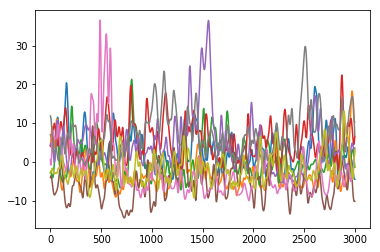

In [11]:
plt.plot(X[-10:-1,:].T)
pass

In [12]:
# plt.plot(np.asarray(df_use['data'][0]))
# pass

## Extract y-labels from this dataframe

In [13]:
y = df_use['choice.class'].values

In [14]:
np.mean(y=='Gamble')

0.5698814409484724

In [17]:
len(y),X.shape

(8772, (8772, 3001))

## Save df_master, df_use, X and y

In [18]:
df_master.to_csv(os.path.join(preproc_dir,'df_master.csv')) 

In [22]:
df_use.to_csv(os.path.join(preproc_dir,'df_use_56.csv')) 

# os.listdir(preproc_dir)

In [29]:
np.save(os.path.join(preproc_dir,'X_use_56.npy'),X)

In [30]:
np.save(os.path.join(preproc_dir,'y_use_56.npy'),y)